In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
#from numpy import random
#np.random.seed(42) # Set seed for reproducibility

from scipy.stats import norm, kstest, probplot, anderson
from scipy.special import erfcinv
from scipy.linalg import sqrtm

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

In [2]:
def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM


def W_ij(diff_mean_i, diff_mean_j, cov_i, cov_j,n_samples):
    
    # Covariance matrices
    #Sigma_X = cov_i
    #Sigma_Y = cov_j 

    # Matrix A (can be arbitrary)
    A = np.dot(sqrtm(np.linalg.inv(cov_i)),sqrtm(np.linalg.inv(cov_j))) #np.random.randn(d, d)  # Random matrix as an example

    # Sampling
    X = np.random.multivariate_normal(diff_mean_i, cov_i, size=n_samples).T  # Shape: (d, n_samples)
    Y = np.random.multivariate_normal(diff_mean_j, cov_j, size=n_samples).T  # Shape: (d, n_samples)

    # Compute W for each sample
    W = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        W[i] = np.dot(X[:, i], np.dot(A, Y[:, i]))  # Shape: (n_samples,)

    return W

In [3]:
# Fixed constants
num_datasets=3
num_parameters=2
df=num_datasets*num_parameters

# Parameters
d = num_parameters  # Dimension
N = num_datasets # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples


# Dataset A

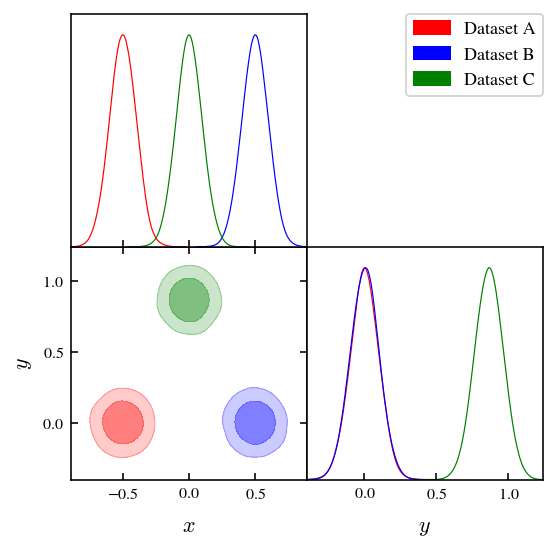

In [4]:
# Fixed constants
num_datasets=3
num_parameters=2
df=num_datasets*num_parameters

# Parameters
d = num_parameters  # Dimension
N = num_datasets # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples


mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)




Center of mass: [-2.3570226 -4.0824829]
PTE = 0.0
n_sigma = inf
PTE = 1.2969398572584535e-21
n_sigma = 9.550001839891598
KstestResult(statistic=0.002648862960552445, pvalue=2.2695288690251093e-61)


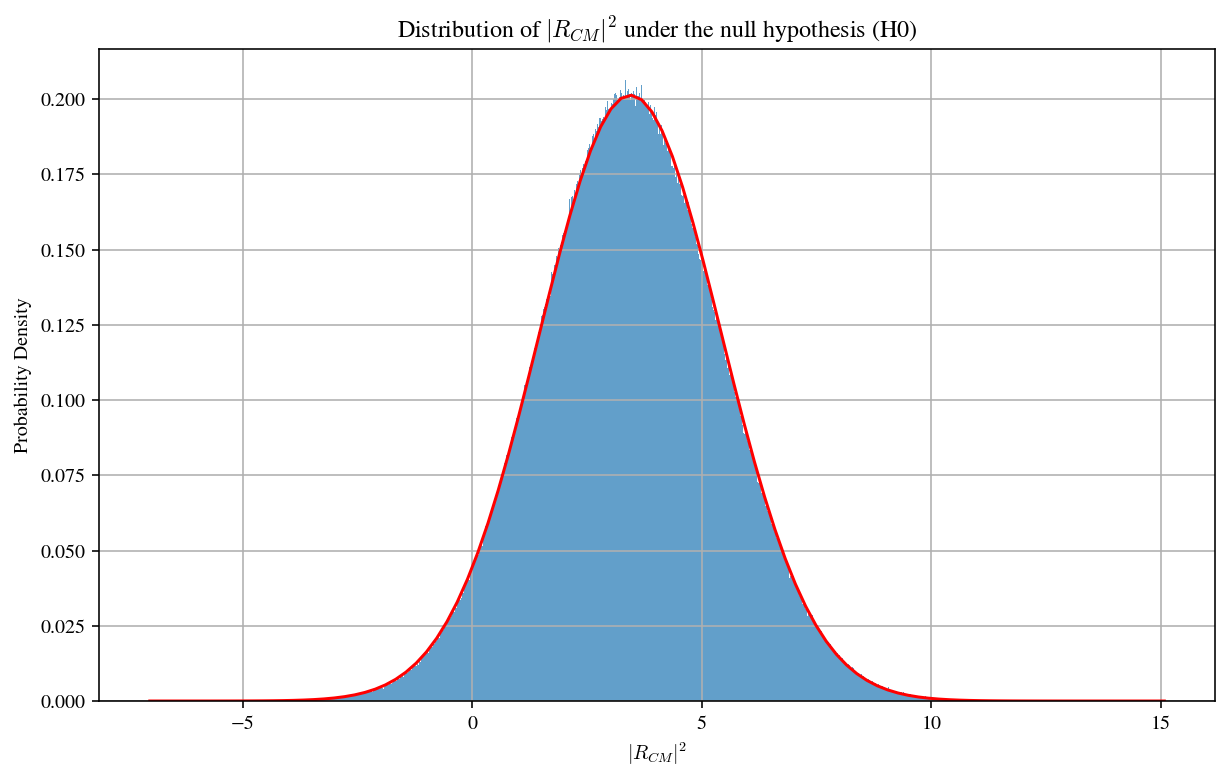

In [5]:
# Fixed constants
num_datasets=3
num_parameters=2
df=num_datasets*num_parameters

# Parameters
d = num_parameters  # Dimension
N = num_datasets # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e7)  # Number of samples

cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C
diff_mean_1 = mean_A - mean_B
diff_mean_2 = mean_A - mean_C
diff_mean_3 = mean_B - mean_C

W_12 = W_ij(diff_mean_1, diff_mean_2, cov_1 ,cov_2,n_samples)
W_13 = W_ij(diff_mean_1, diff_mean_3, cov_1 ,cov_3,n_samples)
W_23 = W_ij(diff_mean_2, diff_mean_3, cov_2 ,cov_3,n_samples)

W_tot = np.sum((W_12, W_13, W_23), axis=0)/L**2
Q_tot = np.random.chisquare(df=d*N, size=n_samples)/L**2
R_tot_2 = W_tot + Q_tot

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

PTE = R_tot_2[R_tot_2 >= np.linalg.norm(R_CM)**2].size/R_tot_2.size

n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

PTE = norm(np.mean(R_tot_2), np.std(R_tot_2)).sf(np.linalg.norm(R_CM)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(R_tot_2, bins=int(np.sqrt(len(R_tot_2))), density=True, alpha=0.7)
t=np.linspace(np.min(R_tot_2), np.max(R_tot_2), 100)
plt.plot(t, norm.pdf(t, np.mean(R_tot_2), np.std(R_tot_2)), color='red', label='Normal PDF')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlabel('$|R_{CM}|^2$')

print(kstest(R_tot_2, norm(loc=np.mean(R_tot_2), scale=np.std(R_tot_2)).cdf))

Anderson-Darling statistic: 156.0999
Nivel de significancia 15.0%: valor crítico = 0.5760
Nivel de significancia 10.0%: valor crítico = 0.6560
Nivel de significancia 5.0%: valor crítico = 0.7870
Nivel de significancia 2.5%: valor crítico = 0.9180
Nivel de significancia 1.0%: valor crítico = 1.0920
Se rechaza H₀: los datos no parecen normales.
KS Statistic: 0.002648862960552445
P-value: 2.2695288690251093e-61
Se rechaza H₀: los datos no parecen provenir de una distribución normal.


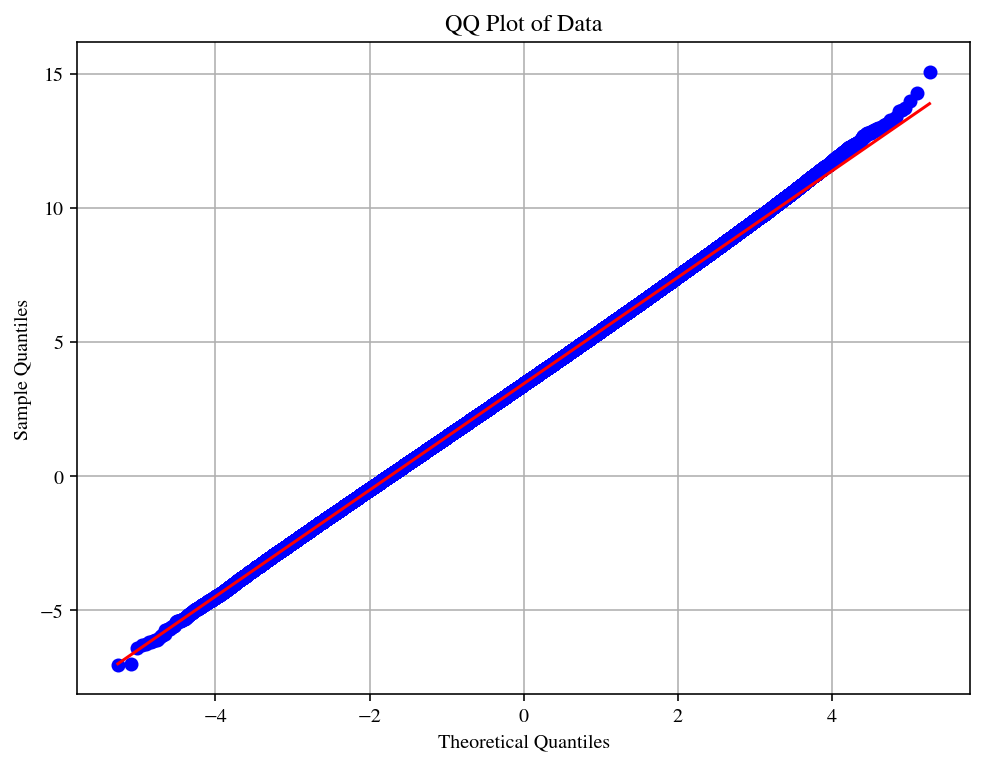

In [6]:
# Generar 10^6 datos (modificá esto si querés probar otra distribución)
#data = np.random.normal(loc=np.mean(R_tot_2), scale=np.std(R_tot_2), size=10**6)
data = R_tot_2

# Anderson-Darling test para normalidad
result = anderson(data, dist='norm')

print(f"Anderson-Darling statistic: {result.statistic:.4f}")
for cv, sig in zip(result.critical_values, result.significance_level):
    print(f"Nivel de significancia {sig}%: valor crítico = {cv:.4f}")
    
if result.statistic < result.critical_values[2]:  # nivel del 5%
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no parecen normales.")

# Realizar el test KS
ks_statistic, p_value = kstest(R_tot_2, 'norm', args=(np.mean(R_tot_2), np.std(R_tot_2)))

# Imprimir resultados
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían provenir de una distribución normal.")
else:
    print("Se rechaza H₀: los datos no parecen provenir de una distribución normal.")

# Crear el QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
probplot(data, dist="norm", plot=ax)

# Personalizar el gráfico
ax.set_title("QQ Plot of Data")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
plt.grid(True)
plt.show()


# Dataset B

Center of mass: [-0.23570226 -0.40824829]
PTE = 0.83475
n_sigma = 0.20861346281702714
PTE = 0.8231822810546602
n_sigma = 0.2234538709973999
KstestResult(statistic=0.036309348566651356, pvalue=0.0)


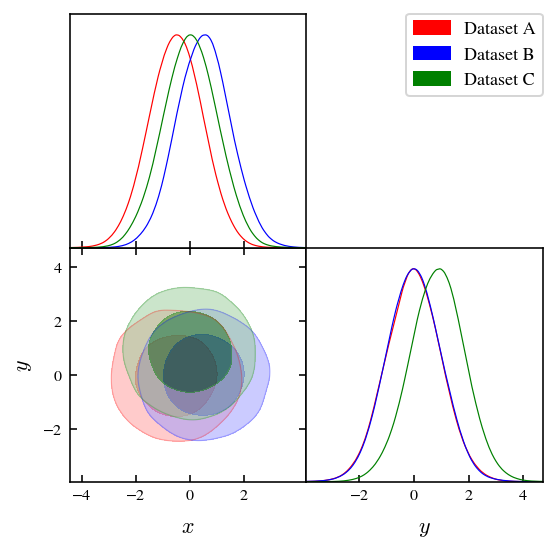

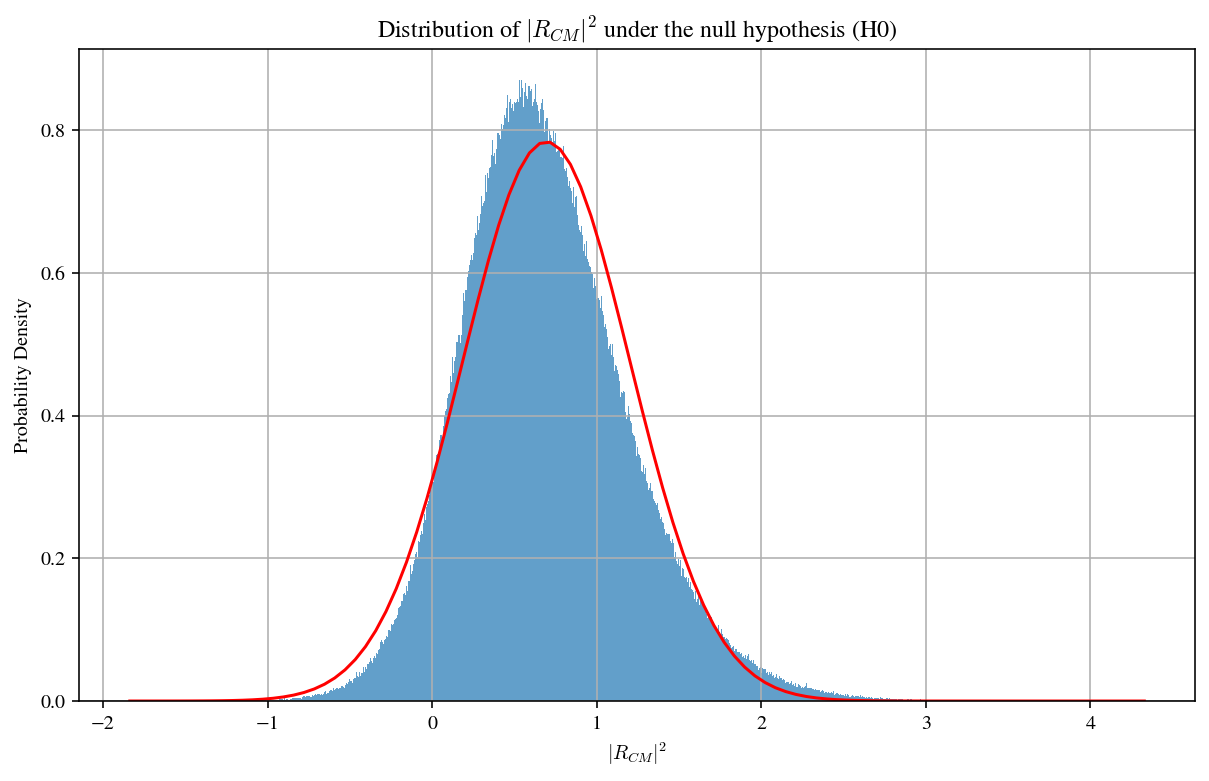

In [7]:
# Fixed constants
num_datasets=3
num_parameters=2
df=num_datasets*num_parameters

# Parameters
d = num_parameters  # Dimension
N = num_datasets # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples


mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = 100*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)

cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C
diff_mean_1 = mean_A - mean_B
diff_mean_2 = mean_A - mean_C
diff_mean_3 = mean_B - mean_C

W_12 = W_ij(diff_mean_1, diff_mean_2, cov_1 ,cov_2,n_samples)
W_13 = W_ij(diff_mean_1, diff_mean_3, cov_1 ,cov_3,n_samples)
W_23 = W_ij(diff_mean_2, diff_mean_3, cov_2 ,cov_3,n_samples)

W_tot = np.sum((W_12, W_13, W_23), axis=0)/L**2
Q_tot = np.random.chisquare(df=d*N, size=n_samples)/L**2
R_tot_2 = W_tot + Q_tot

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

PTE = R_tot_2[R_tot_2 >= np.linalg.norm(R_CM)**2].size/R_tot_2.size
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')


PTE = norm(np.mean(R_tot_2), np.std(R_tot_2)).sf(np.linalg.norm(R_CM)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(R_tot_2, bins=int(np.sqrt(len(R_tot_2))), density=True, alpha=0.7)
t=np.linspace(np.min(R_tot_2), np.max(R_tot_2), 100)
plt.plot(t, norm.pdf(t, np.mean(R_tot_2), np.std(R_tot_2)), color='red', label='Normal PDF')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlabel('$|R_{CM}|^2$')

print(kstest(R_tot_2, norm(loc=np.mean(R_tot_2), scale=np.std(R_tot_2)).cdf))

Anderson-Darling statistic: 3037.6471
Nivel de significancia 15.0%: valor crítico = 0.5760
Nivel de significancia 10.0%: valor crítico = 0.6560
Nivel de significancia 5.0%: valor crítico = 0.7870
Nivel de significancia 2.5%: valor crítico = 0.9180
Nivel de significancia 1.0%: valor crítico = 1.0920
Se rechaza H₀: los datos no parecen normales.
KS Statistic: 0.036309348566651356
P-value: 0.0
Se rechaza H₀: los datos no parecen provenir de una distribución normal.


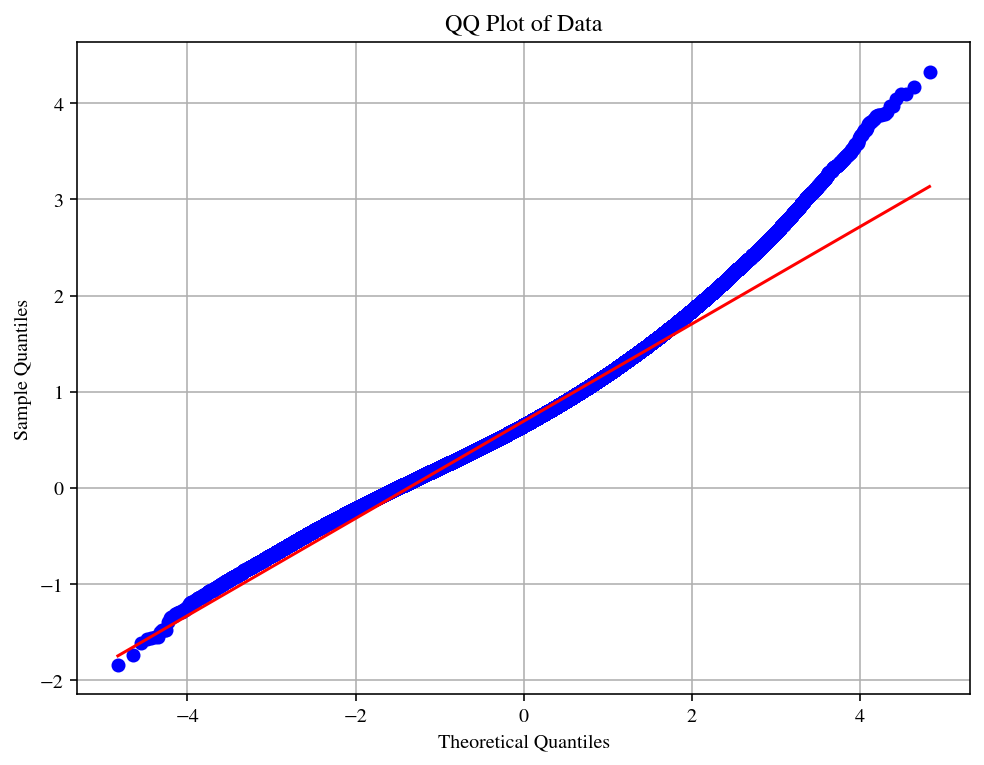

In [8]:
# Generar 10^6 datos (modificá esto si querés probar otra distribución)
#data = np.random.normal(loc=np.mean(R_tot_2), scale=np.std(R_tot_2), size=10**6)
data = R_tot_2

# Anderson-Darling test para normalidad
result = anderson(data, dist='norm')

print(f"Anderson-Darling statistic: {result.statistic:.4f}")
for cv, sig in zip(result.critical_values, result.significance_level):
    print(f"Nivel de significancia {sig}%: valor crítico = {cv:.4f}")
    
if result.statistic < result.critical_values[2]:  # nivel del 5%
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no parecen normales.")

# Realizar el test KS
ks_statistic, p_value = kstest(R_tot_2, 'norm', args=(np.mean(R_tot_2), np.std(R_tot_2)))

# Imprimir resultados
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían provenir de una distribución normal.")
else:
    print("Se rechaza H₀: los datos no parecen provenir de una distribución normal.")

# Crear el QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
probplot(data, dist="norm", plot=ax)

# Personalizar el gráfico
ax.set_title("QQ Plot of Data")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
plt.grid(True)
plt.show()


# Dataset C

Center of mass: [-0.37966746 -0.49136664]
PTE = 0.731386
n_sigma = 0.3432824266208902
PTE = 0.7356031955527137
n_sigma = 0.33768152917553795
KstestResult(statistic=0.03359739504873793, pvalue=0.0)


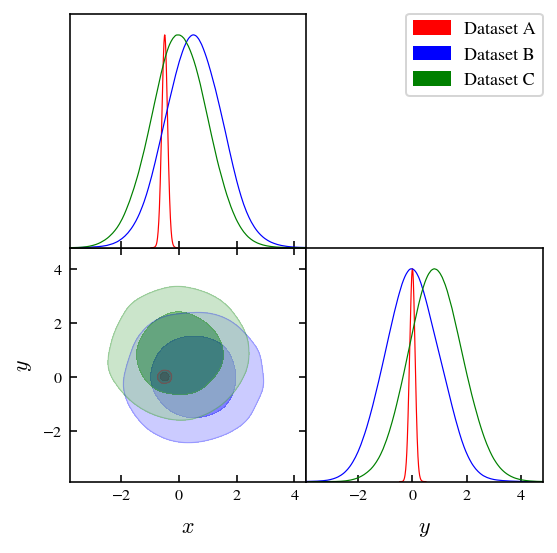

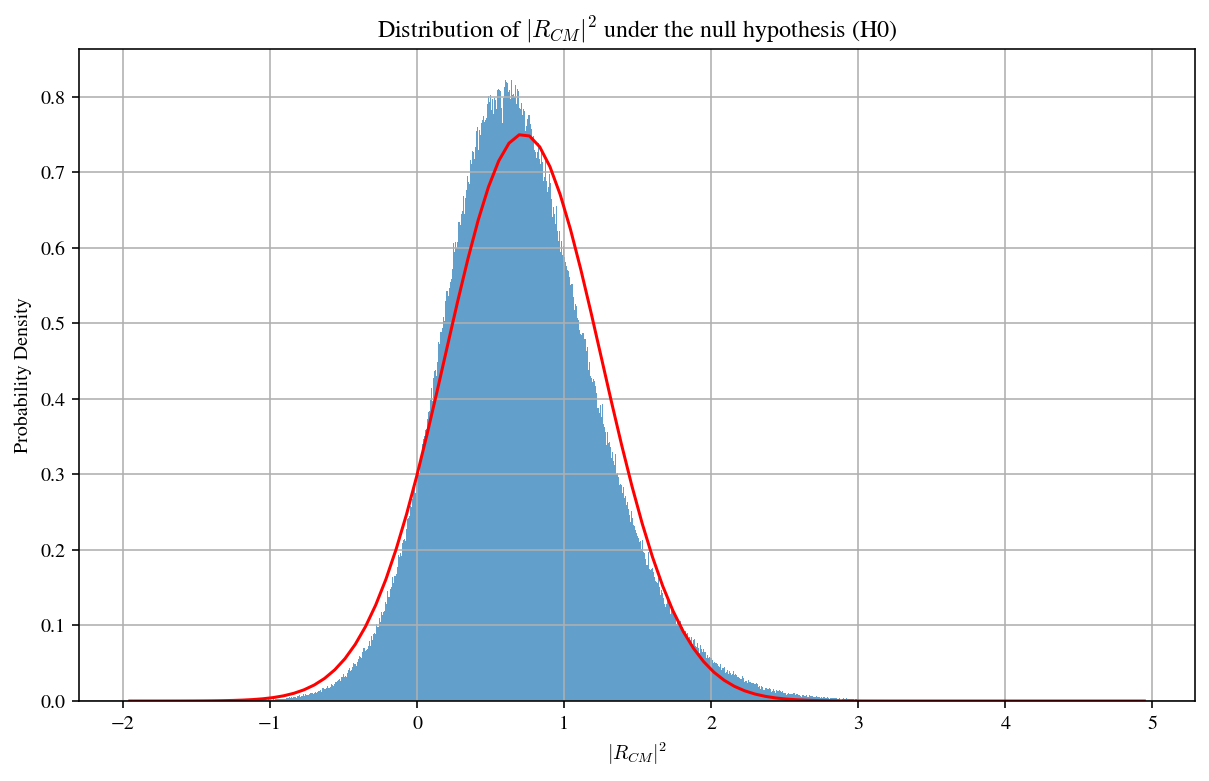

In [9]:
# Fixed constants
num_datasets=3
num_parameters=2
df=num_datasets*num_parameters

# Parameters
d = num_parameters  # Dimension
N = num_datasets # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples


mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = 100*cov_A.copy()
cov_C = 100*cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)

cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C
diff_mean_1 = mean_A - mean_B
diff_mean_2 = mean_A - mean_C
diff_mean_3 = mean_B - mean_C

W_12 = W_ij(diff_mean_1, diff_mean_2, cov_1 ,cov_2,n_samples)
W_13 = W_ij(diff_mean_1, diff_mean_3, cov_1 ,cov_3,n_samples)
W_23 = W_ij(diff_mean_2, diff_mean_3, cov_2 ,cov_3,n_samples)

W_tot = np.sum((W_12, W_13, W_23), axis=0)/L**2
Q_tot = np.random.chisquare(df=d*N, size=n_samples)/L**2
R_tot_2 = W_tot + Q_tot

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

PTE = R_tot_2[R_tot_2 >= np.linalg.norm(R_CM)**2].size/R_tot_2.size
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

PTE = norm(np.mean(R_tot_2), np.std(R_tot_2)).sf(np.linalg.norm(R_CM)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(R_tot_2, bins=int(np.sqrt(len(R_tot_2))), density=True, alpha=0.7)
t=np.linspace(np.min(R_tot_2), np.max(R_tot_2), 100)
plt.plot(t, norm.pdf(t, np.mean(R_tot_2), np.std(R_tot_2)), color='red', label='Normal PDF')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlabel('$|R_{CM}|^2$')

print(kstest(R_tot_2, norm(loc=np.mean(R_tot_2), scale=np.std(R_tot_2)).cdf))


Anderson-Darling statistic: 2537.9415
Nivel de significancia 15.0%: valor crítico = 0.5760
Nivel de significancia 10.0%: valor crítico = 0.6560
Nivel de significancia 5.0%: valor crítico = 0.7870
Nivel de significancia 2.5%: valor crítico = 0.9180
Nivel de significancia 1.0%: valor crítico = 1.0920
Se rechaza H₀: los datos no parecen normales.
KS Statistic: 0.03359739504873793
P-value: 0.0
Se rechaza H₀: los datos no parecen provenir de una distribución normal.


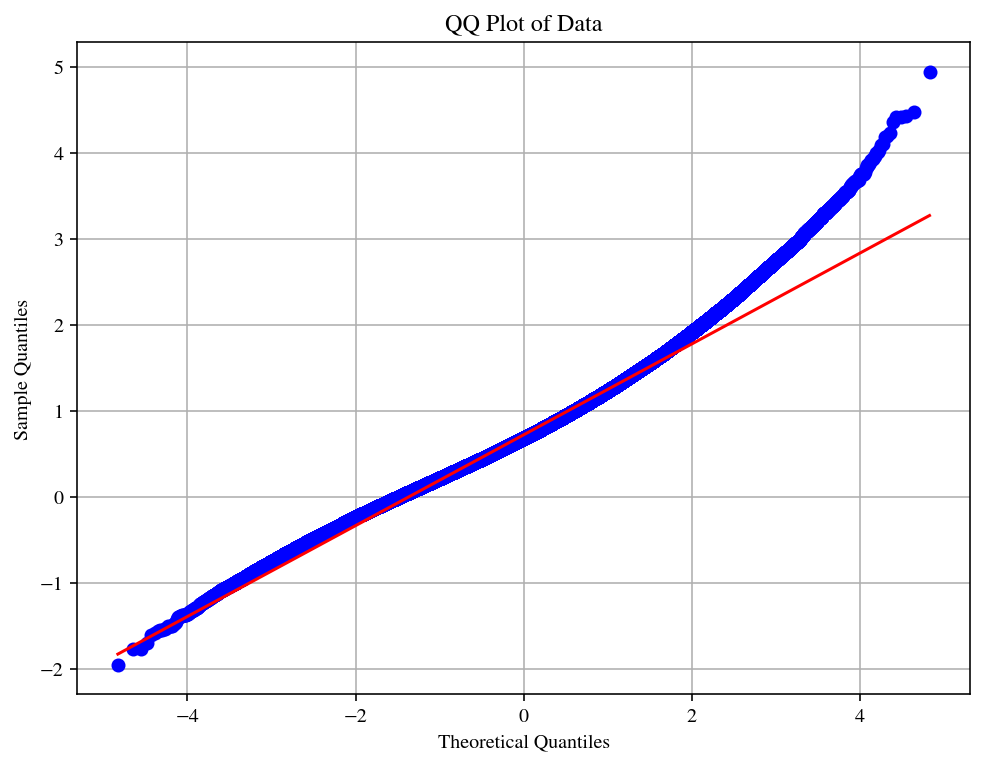

In [10]:
# Generar 10^6 datos (modificá esto si querés probar otra distribución)
#data = np.random.normal(loc=np.mean(R_tot_2), scale=np.std(R_tot_2), size=10**6)
data = R_tot_2

# Anderson-Darling test para normalidad
result = anderson(data, dist='norm')

print(f"Anderson-Darling statistic: {result.statistic:.4f}")
for cv, sig in zip(result.critical_values, result.significance_level):
    print(f"Nivel de significancia {sig}%: valor crítico = {cv:.4f}")
    
if result.statistic < result.critical_values[2]:  # nivel del 5%
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no parecen normales.")

# Realizar el test KS
ks_statistic, p_value = kstest(R_tot_2, 'norm', args=(np.mean(R_tot_2), np.std(R_tot_2)))

# Imprimir resultados
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían provenir de una distribución normal.")
else:
    print("Se rechaza H₀: los datos no parecen provenir de una distribución normal.")

# Crear el QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
probplot(data, dist="norm", plot=ax)

# Personalizar el gráfico
ax.set_title("QQ Plot of Data")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

# Dataset D

Center of mass: [-2.3570226  -0.57448499]
PTE = 4.04e-05
n_sigma = 4.105180102445612
PTE = 1.2787292418196531e-05
n_sigma = 4.363713669283319
KstestResult(statistic=0.0039176355089317605, pvalue=9.77255808454396e-134)


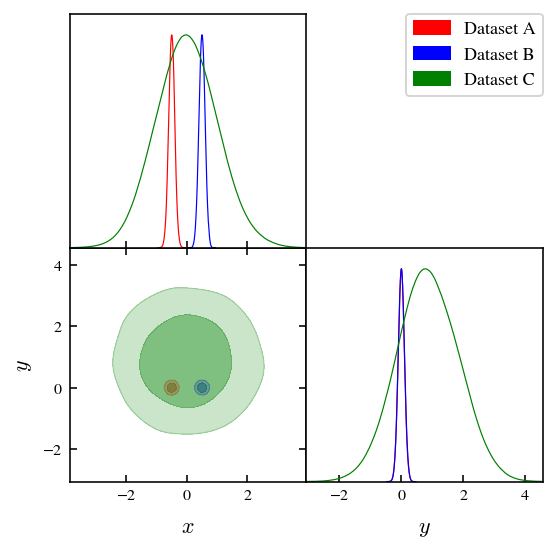

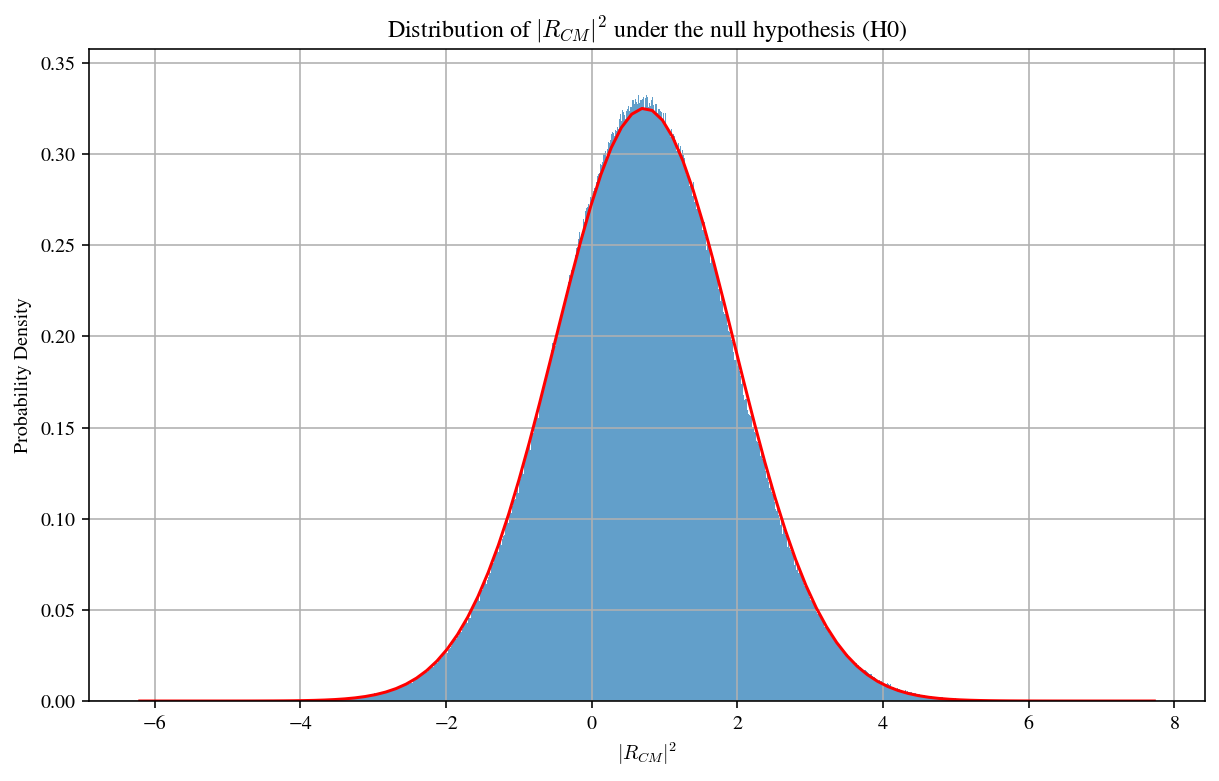

In [11]:
# Fixed constants
num_datasets=3
num_parameters=2
df=num_datasets*num_parameters
n_samples=int(1e7)

# Parameters
d = num_parameters  # Dimension
N = num_datasets  # Number of datasets
L = N*(N-1)/2  # Number of tension vectors


mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = 100*cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

colors = ['red', 'blue', 'green']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)

cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C
diff_mean_1 = mean_A - mean_B
diff_mean_2 = mean_A - mean_C
diff_mean_3 = mean_B - mean_C

W_12 = W_ij(diff_mean_1, diff_mean_2, cov_1 ,cov_2,n_samples)
W_13 = W_ij(diff_mean_1, diff_mean_3, cov_1 ,cov_3,n_samples)
W_23 = W_ij(diff_mean_2, diff_mean_3, cov_2 ,cov_3,n_samples)

W_tot = np.sum((W_12, W_13, W_23), axis=0)/L**2
Q_tot = np.random.chisquare(df=d*N, size=n_samples)/L**2
R_tot_2 = W_tot + Q_tot

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

PTE = R_tot_2[R_tot_2 >= np.linalg.norm(R_CM)**2].size/R_tot_2.size
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

PTE = norm(np.mean(R_tot_2), np.std(R_tot_2)).sf(np.linalg.norm(R_CM)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(R_tot_2, bins=int(np.sqrt(len(R_tot_2))), density=True, alpha=0.7)
t=np.linspace(np.min(R_tot_2), np.max(R_tot_2), 100)
plt.plot(t, norm.pdf(t, np.mean(R_tot_2), np.std(R_tot_2)), color='red', label='Normal PDF')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlabel('$|R_{CM}|^2$')

print(kstest(R_tot_2, norm(loc=np.mean(R_tot_2), scale=np.std(R_tot_2)).cdf))

Anderson-Darling statistic: 323.8907
Nivel de significancia 15.0%: valor crítico = 0.5760
Nivel de significancia 10.0%: valor crítico = 0.6560
Nivel de significancia 5.0%: valor crítico = 0.7870
Nivel de significancia 2.5%: valor crítico = 0.9180
Nivel de significancia 1.0%: valor crítico = 1.0920
Se rechaza H₀: los datos no parecen normales.
KS Statistic: 0.0039176355089317605
P-value: 9.77255808454396e-134
Se rechaza H₀: los datos no parecen provenir de una distribución normal.


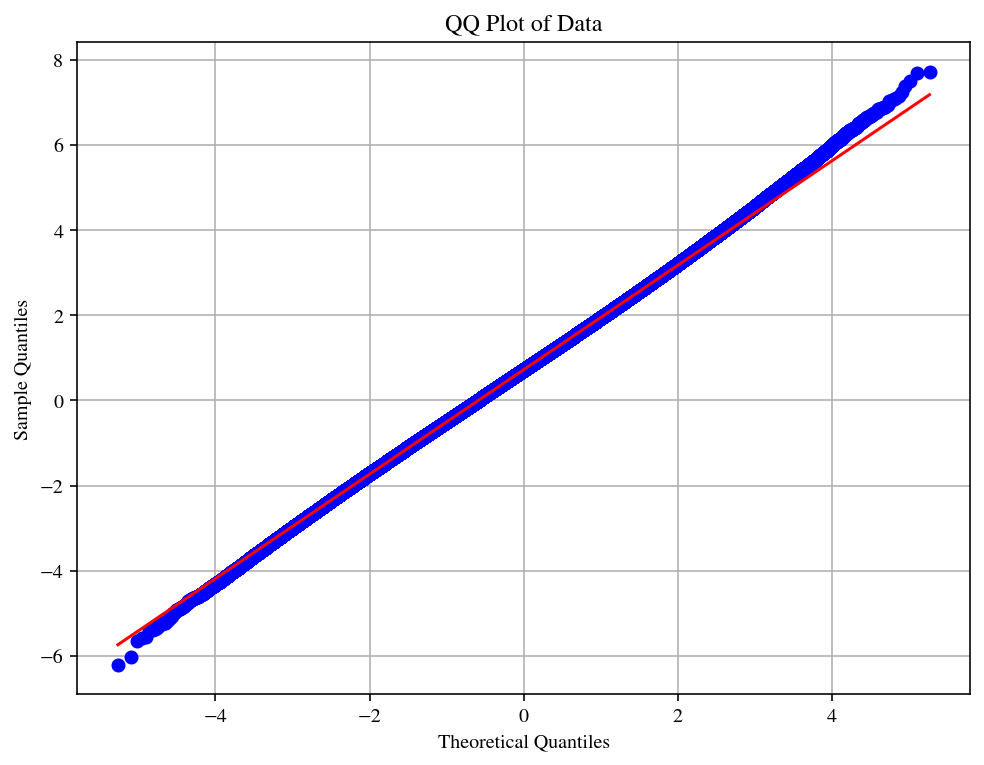

In [12]:
# Generar 10^6 datos (modificá esto si querés probar otra distribución)
#data = np.random.normal(loc=np.mean(R_tot_2), scale=np.std(R_tot_2), size=10**6)
data = R_tot_2

# Anderson-Darling test para normalidad
result = anderson(data, dist='norm')

print(f"Anderson-Darling statistic: {result.statistic:.4f}")
for cv, sig in zip(result.critical_values, result.significance_level):
    print(f"Nivel de significancia {sig}%: valor crítico = {cv:.4f}")
    
if result.statistic < result.critical_values[2]:  # nivel del 5%
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no parecen normales.")

# Realizar el test KS
ks_statistic, p_value = kstest(R_tot_2, 'norm', args=(np.mean(R_tot_2), np.std(R_tot_2)))

# Imprimir resultados
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían provenir de una distribución normal.")
else:
    print("Se rechaza H₀: los datos no parecen provenir de una distribución normal.")

# Crear el QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
probplot(data, dist="norm", plot=ax)

# Personalizar el gráfico
ax.set_title("QQ Plot of Data")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
plt.grid(True)
plt.show()


# Real Data

In [13]:
# Fixed constants
num_datasets=4
num_parameters=2
df=num_datasets*num_parameters
n_samples=int(1e6)

# Parameters
d = num_parameters  # Dimension
N = num_datasets  # Number of datasets
L = N*(N-1)/2  # Number of tension vectors

n_samples = int(1e6)  # Number of samples

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))
os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='old_metrics/lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared paameters

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)


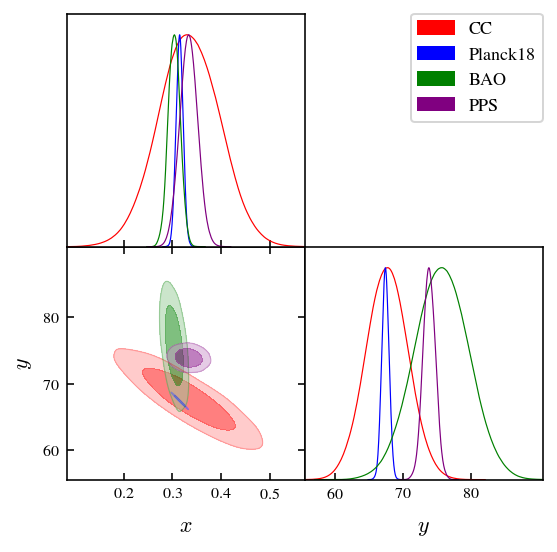

In [14]:
samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)
samps_D = np.random.multivariate_normal(mean_D, cov_D, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label='Dataset D')

colors = ['red', 'blue', 'green', 'purple']


g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_D],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO', 'PPS'])
os.chdir(os.path.join(path_git, 'docs', 'example_notebooks', 'paper','PRL', 'figures'))
g.export('dist_data.png')

Center of mass: [-1.1227663  -1.84922768]
PTE = 0.0
n_sigma = inf
PTE = 8.14901704516676e-09
n_sigma = 5.76534664793461


Text(0.5, 0, '$|R_{CM}|^2$')

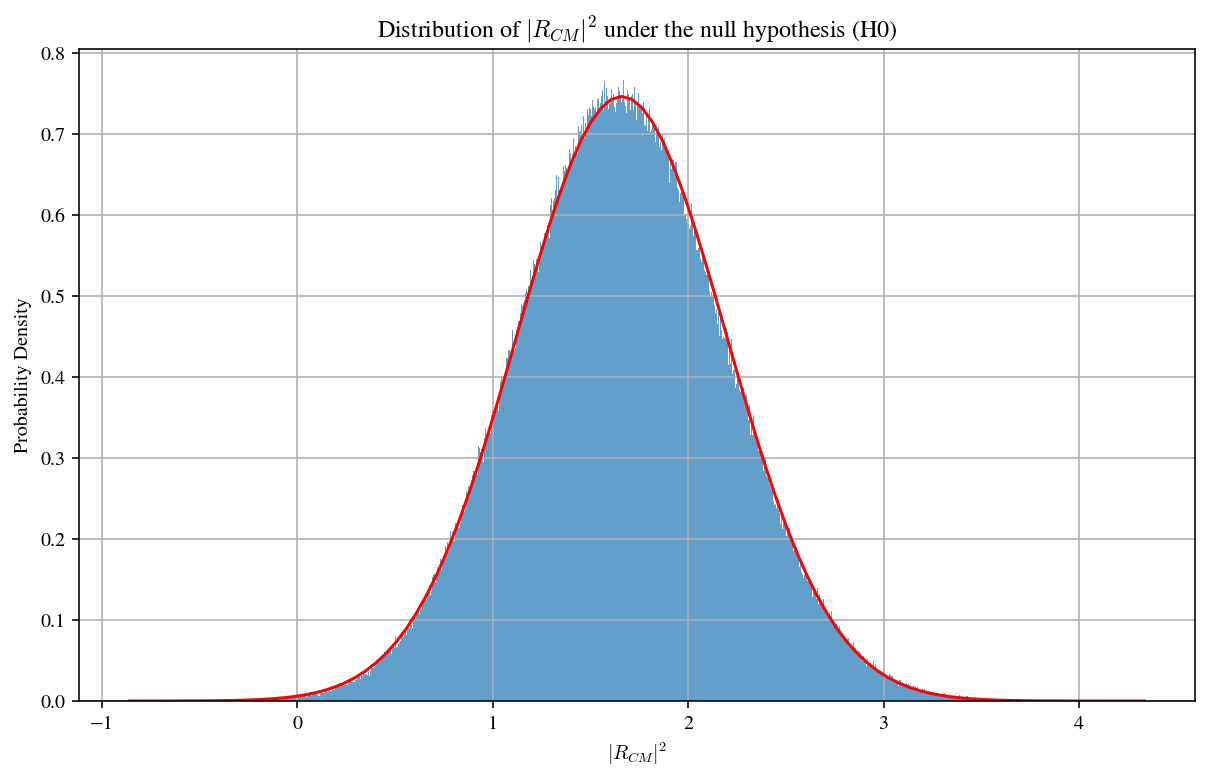

In [15]:
cov_1 = cov_A + cov_B
cov_2 = cov_A + cov_C
cov_3 = cov_B + cov_C
cov_4 = cov_A + cov_D
cov_5 = cov_B + cov_D
cov_6 = cov_C + cov_D

diff_mean_1 = mean_A - mean_B
diff_mean_2 = mean_A - mean_C
diff_mean_3 = mean_B - mean_C
diff_mean_4 = mean_A - mean_D
diff_mean_5 = mean_B - mean_D
diff_mean_6 = mean_C - mean_D

W_12 = W_ij(diff_mean_1, diff_mean_2, cov_1 ,cov_2,n_samples)
W_13 = W_ij(diff_mean_1, diff_mean_3, cov_1 ,cov_3,n_samples)
W_14 = W_ij(diff_mean_1, diff_mean_4, cov_1 ,cov_4,n_samples)
W_15 = W_ij(diff_mean_1, diff_mean_5, cov_1 ,cov_5,n_samples)
W_16 = W_ij(diff_mean_1, diff_mean_6, cov_1 ,cov_6,n_samples)
W_23 = W_ij(diff_mean_2, diff_mean_3, cov_2 ,cov_3,n_samples)
W_24 = W_ij(diff_mean_2, diff_mean_4, cov_2 ,cov_4,n_samples)
W_25 = W_ij(diff_mean_2, diff_mean_5, cov_2 ,cov_5,n_samples)
W_26 = W_ij(diff_mean_2, diff_mean_6, cov_2 ,cov_6,n_samples)
W_34 = W_ij(diff_mean_3, diff_mean_4, cov_3 ,cov_4,n_samples)
W_35 = W_ij(diff_mean_3, diff_mean_5, cov_3 ,cov_5,n_samples)
W_36 = W_ij(diff_mean_3, diff_mean_6, cov_3 ,cov_6,n_samples)
W_45 = W_ij(diff_mean_4, diff_mean_5, cov_4 ,cov_5,n_samples)
W_46 = W_ij(diff_mean_4, diff_mean_6, cov_4 ,cov_6,n_samples)
W_56 = W_ij(diff_mean_5, diff_mean_6, cov_5 ,cov_6,n_samples)

W_tot = np.sum((W_12, W_13, W_14, W_15, W_16, W_23, W_24, W_25,\
                W_26, W_34, W_35, W_36, W_45, W_46, W_56), axis=0)/L**2
Q_tot = np.random.chisquare(df=d*N, size=n_samples)/L**2
R_tot_2 = W_tot + Q_tot

r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))

# Example usage:
vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

PTE = R_tot_2[R_tot_2 >= np.linalg.norm(R_CM)**2].size/R_tot_2.size

n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

PTE = norm(np.mean(R_tot_2), np.std(R_tot_2)).sf(np.linalg.norm(R_CM)**2)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'PTE = {PTE}')
print(f'n_sigma = {n_sigma}')

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(R_tot_2, bins=int(np.sqrt(len(R_tot_2))), density=True, alpha=0.7)
t=np.linspace(np.min(R_tot_2), np.max(R_tot_2), 100)
plt.plot(t, norm.pdf(t, np.mean(R_tot_2), np.std(R_tot_2)), color='red', label='Normal PDF')
plt.title('Distribution of $|R_{CM}|^2$ under the null hypothesis (H0)')
plt.xlabel('$|R_{CM}|^2$')
plt.ylabel('Probability Density')
plt.grid(True)
plt.xlabel('$|R_{CM}|^2$')

Anderson-Darling statistic: 26.7913
Nivel de significancia 15.0%: valor crítico = 0.5760
Nivel de significancia 10.0%: valor crítico = 0.6560
Nivel de significancia 5.0%: valor crítico = 0.7870
Nivel de significancia 2.5%: valor crítico = 0.9180
Nivel de significancia 1.0%: valor crítico = 1.0920
Se rechaza H₀: los datos no parecen normales.
KS Statistic: 0.0035456553242329547
P-value: 2.4008225583805118e-11
Se rechaza H₀: los datos no parecen provenir de una distribución normal.


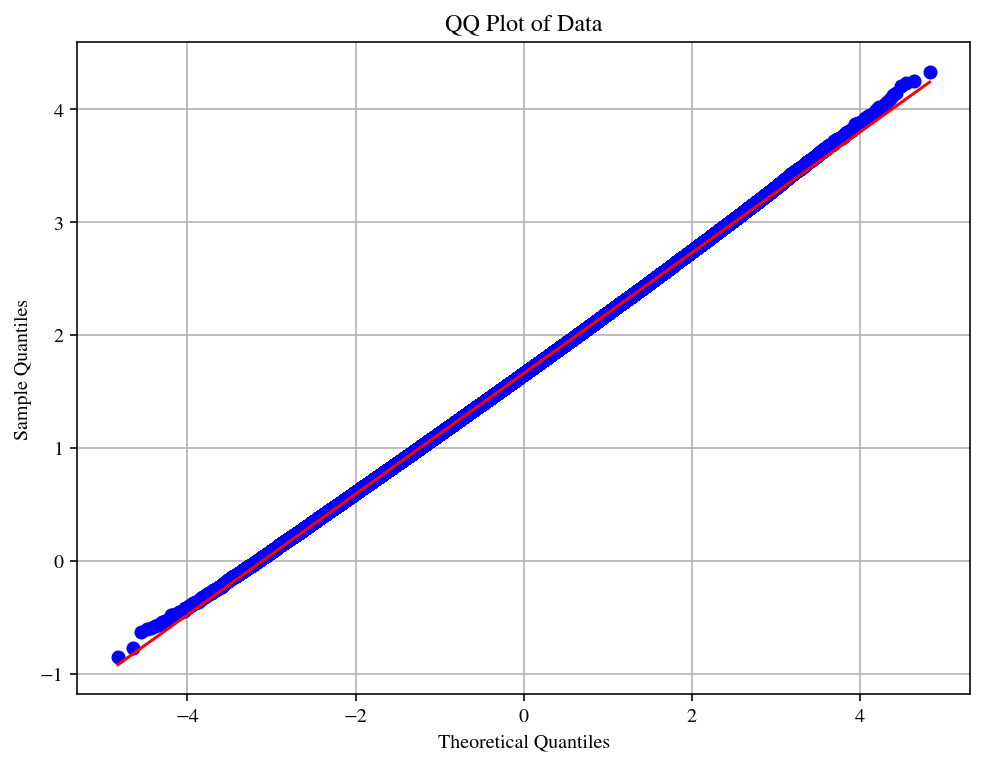

In [17]:
# Generar 10^6 datos (modificá esto si querés probar otra distribución)
#data = np.random.normal(loc=np.mean(R_tot_2), scale=np.std(R_tot_2), size=10**6)
data = R_tot_2

# Anderson-Darling test para normalidad
result = anderson(data, dist='norm')

print(f"Anderson-Darling statistic: {result.statistic:.4f}")
for cv, sig in zip(result.critical_values, result.significance_level):
    print(f"Nivel de significancia {sig}%: valor crítico = {cv:.4f}")
    
if result.statistic < result.critical_values[2]:  # nivel del 5%
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no parecen normales.")

# Realizar el test KS
ks_statistic, p_value = kstest(R_tot_2, 'norm', args=(np.mean(R_tot_2), np.std(R_tot_2)))

# Imprimir resultados
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían provenir de una distribución normal.")
else:
    print("Se rechaza H₀: los datos no parecen provenir de una distribución normal.")

# Crear el QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
probplot(data, dist="norm", plot=ax)

# Personalizar el gráfico
ax.set_title("QQ Plot of Data")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
plt.grid(True)
plt.show()
